In [7]:
# Urban Housing Market Cycles and Gentrification: An Agent-Based Model

Authors: [Ziqian Qin/Yao Qin] (Student ID: 23934529/24144144)
         

CITS4403 Computational Modelling Project

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2074683248.py, line 3)

## 1. Problem Statement

Urban housing markets are complex systems influenced by various factors such as economic conditions, population dynamics, and policy interventions. Gentrification, a process where affluent individuals move into previously low-income areas, leading to neighborhood changes and potential displacement of original residents, is a particularly interesting phenomenon within this context.

This project aims to explore the dynamics of housing market cycles and gentrification using an agent-based model (ABM). We are motivated by the need to understand how individual decisions of homeowners, renters, investors, and businesses collectively shape urban neighborhoods and contribute to market fluctuations and demographic shifts.

### Suitability for Agent-Based Modeling

ABM is particularly well-suited for this case due to the following reasons:

1. Heterogeneous agents: The housing market involves diverse actors (residents, investors, businesses) with varying attributes and decision-making processes.
2. Local interactions: Neighborhood effects and social influences play a crucial role in housing decisions and property values.
3. Emergence: Gentrification and market cycles emerge from the collective behavior of individual agents, rather than being centrally controlled.
4. Adaptive behavior: Agents can adjust their decisions based on changing market conditions and neighborhood characteristics.

### Complexity of the Case

The complexity of this case arises from several factors:

- Multiple interacting agent types (residents, investors, properties, businesses)
- Dynamic neighborhood characteristics (amenities, property values)
- Feedback loops between property values, resident demographics, and business activities
- Time lags in market responses and neighborhood changes
- Policy interventions and their unintended consequences

By simulating this complex system, we aim to gain insights into the mechanisms driving housing market cycles and gentrification processes, potentially informing urban planning and policy decisions.


## 2. Model Design

Our agent-based model consists of the following key components:

### Agents

1. Residents: Characterized by income, satisfaction, and housing preferences.
2. Investors: Have capital and make property investment decisions.
3. Properties: Represent housing units with evolving values.
4. Local Businesses: Influence neighborhood amenities and respond to demographic changes.

### Environment

The environment is represented by a grid, where each cell can contain multiple agents.

### Key Rules and Interactions

- Resident decision-making:
  - Residents decide to move based on satisfaction levels, which depend on affordability and neighborhood characteristics.
  - When moving, residents choose properties based on their preferences and income constraints.
- Property value dynamics:
  - Property values are updated based on neighboring property values and local amenities.
- Investor behavior:
  - Investors buy and sell properties based on expected return on investment.
- Business dynamics:
  - Businesses open or close based on the local demographic composition and profitability.

### Model Parameters

- Initial income distribution
- Initial property value distribution
- Business opening/closing thresholds
- Investor capital distribution
- Resident mobility rate

## 3. Model Implementation

Let's implement our model using the Mesa library for agent-based modeling in Python.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import pandas as pd
import matplotlib.pyplot as plt

class Resident(Agent):
    def __init__(self, unique_id, model, income):
        super().__init__(unique_id, model)
        self.income = income
        self.satisfaction = 1.0
        self.property = None

    def step(self):
        self.update_satisfaction()
        if self.satisfaction < 0.5:
            self.consider_moving()

    def update_satisfaction(self):
        if self.property:
            neighborhood = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
            property_neighbors = [agent for agent in neighborhood if isinstance(agent, Property)]
            if property_neighbors:
                avg_neighbor_value = np.mean([agent.value for agent in property_neighbors])
                self.satisfaction = 1 - abs(self.property.value - avg_neighbor_value) / max(self.property.value, avg_neighbor_value)
            else:
                self.satisfaction -= 0.1
        else:
            self.satisfaction -= 0.1

    def consider_moving(self):
        affordable_properties = [prop for prop in self.model.properties if prop.value <= self.income * 3 and prop.owner is None]
        if affordable_properties:
            new_property = self.random.choice(affordable_properties)
            if self.property:
                self.property.owner = None
            self.property = new_property
            new_property.owner = self
            if new_property.pos is not None:
                self.model.grid.move_agent(self, new_property.pos)

class Investor(Agent):
    def __init__(self, unique_id, model, capital):
        super().__init__(unique_id, model)
        self.capital = capital
        self.properties = []

    def step(self):
        if self.capital > 0:
            self.consider_buying()
        self.consider_selling()

    def consider_buying(self):
        affordable_properties = [prop for prop in self.model.properties if prop.value <= self.capital and prop.owner is None]
        if affordable_properties:
            property_to_buy = max(affordable_properties, key=lambda p: p.expected_return())
            self.buy_property(property_to_buy)

    def buy_property(self, property):
        self.capital -= property.value
        self.properties.append(property)
        property.owner = self

    def consider_selling(self):
        for property in self.properties:
            if property.expected_return() < 0.05:
                self.sell_property(property)

    def sell_property(self, property):
        self.capital += property.value
        self.properties.remove(property)
        property.owner = None

class Property(Agent):
    def __init__(self, unique_id, model, value):
        super().__init__(unique_id, model)
        self.value = value
        self.owner = None

    def step(self):
        self.update_value()

    def update_value(self):
        neighborhood = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        property_neighbors = [agent for agent in neighborhood if isinstance(agent, Property)]
        if property_neighbors:
            avg_neighbor_value = np.mean([agent.value for agent in property_neighbors])
            self.value = 0.9 * self.value + 0.1 * avg_neighbor_value
        amenities = sum(1 for agent in neighborhood if isinstance(agent, Business))
        self.value *= (1 + 0.05 * amenities)

    def expected_return(self):
        return (self.value - self.model.initial_avg_property_value) / self.model.initial_avg_property_value

class Business(Agent):
    def __init__(self, unique_id, model, income_threshold):
        super().__init__(unique_id, model)
        self.income_threshold = income_threshold

    def step(self):
        neighborhood = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        residents = [agent for agent in neighborhood if isinstance(agent, Resident)]
        if residents:
            avg_income = np.mean([agent.income for agent in residents])
            if avg_income < self.income_threshold:
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
            elif self.random.random() < 0.1:
                empty_cells = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
                empty_cells = [cell for cell in empty_cells if self.model.grid.is_cell_empty(cell)]
                if empty_cells:
                    new_pos = self.random.choice(empty_cells)
                    new_business = Business(self.model.next_id(), self.model, self.income_threshold)
                    self.model.grid.place_agent(new_business, new_pos)
                    self.model.schedule.add(new_business)

class HousingMarketModel(Model):
    def __init__(self, num_residents, num_investors, width, height):
        super().__init__()
        self.num_residents = num_residents
        self.num_investors = num_investors
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.properties = []
        self.current_id = 0
        
        self.create_properties()
        self.create_residents()
        self.create_investors()
        self.create_businesses()
        
        self.initial_avg_property_value = np.mean([p.value for p in self.properties])
        
        self.datacollector = DataCollector(
            model_reporters={
                "Average Property Value": self.average_property_value,
                "Gini Coefficient": self.gini_coefficient,
                "Neighborhood Diversity": self.neighborhood_diversity
            },
            agent_reporters={
                "Income": lambda a: a.income if isinstance(a, Resident) else None,
                "Property Value": lambda a: a.value if isinstance(a, Property) else None
            }
        )

    def create_properties(self):
        num_properties = int(self.grid.width * self.grid.height * 0.8)  # 使用80%的网格用于属性
        for _ in range(num_properties):
            value = self.random.normalvariate(100000, 20000)
            property = Property(self.next_id(), self, value)
            self.schedule.add(property)
            self.properties.append(property)
            
            empty_cells = list(self.grid.empties)
            if empty_cells:
                pos = self.random.choice(empty_cells)
                self.grid.place_agent(property, pos)
            else:
                print(f"Warning: No empty cell for property {property.unique_id}")

    def create_residents(self):
        for _ in range(self.num_residents):
            income = self.random.lognormvariate(10, 0.5)
            resident = Resident(self.next_id(), self, income)
            self.schedule.add(resident)
            
            empty_cells = list(self.grid.empties)
            if empty_cells:
                pos = self.random.choice(empty_cells)
                self.grid.place_agent(resident, pos)
            else:
                print(f"Warning: No empty cell for resident {resident.unique_id}")

    def create_investors(self):
        for _ in range(self.num_investors):
            capital = self.random.lognormvariate(12, 1)
            investor = Investor(self.next_id(), self, capital)
            self.schedule.add(investor)
            
            empty_cells = list(self.grid.empties)
            if empty_cells:
                pos = self.random.choice(empty_cells)
                self.grid.place_agent(investor, pos)
            else:
                print(f"Warning: No empty cell for investor {investor.unique_id}")

    def create_businesses(self):
        num_businesses = int(0.1 * self.num_residents)
        for _ in range(num_businesses):
            income_threshold = self.random.normalvariate(50000, 10000)
            business = Business(self.next_id(), self, income_threshold)
            self.schedule.add(business)
            
            empty_cells = list(self.grid.empties)
            if empty_cells:
                pos = self.random.choice(empty_cells)
                self.grid.place_agent(business, pos)
            else:
                print(f"Warning: No empty cell for business {business.unique_id}")

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

    def average_property_value(self):
        return np.mean([p.value for p in self.properties])

    def gini_coefficient(self):
        resident_incomes = [a.income for a in self.schedule.agents if isinstance(a, Resident)]
        sorted_incomes = np.sort(resident_incomes)
        index = np.arange(1, len(sorted_incomes) + 1)
        return (np.sum((2 * index - len(sorted_incomes) - 1) * sorted_incomes)) / (len(sorted_incomes) * np.sum(sorted_incomes))

    def neighborhood_diversity(self):
        diversity_scores = []
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                neighborhood = self.grid.get_neighbors((x, y), moore=True, include_center=True)
                residents = [a for a in neighborhood if isinstance(a, Resident)]
                if residents:
                    incomes = [r.income for r in residents]
                    diversity_scores.append(np.std(incomes) / np.mean(incomes))
        return np.mean(diversity_scores)

In [9]:
# Run the simulation
model = HousingMarketModel(1000, 50, 100, 100)  # 增加网格大小到 100x100
for i in range(100):
    model.step()

In [10]:
# Collect data
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

In [11]:
# Display basic statistics
print("Final Statistics:")
print(f"Average Property Value: ${model_data['Average Property Value'].iloc[-1]:.2f}")
print(f"Gini Coefficient: {model_data['Gini Coefficient'].iloc[-1]:.4f}")
print(f"Neighborhood Diversity: {model_data['Neighborhood Diversity'].iloc[-1]:.4f}")


Final Statistics:
Average Property Value: $269304.10
Gini Coefficient: 0.2713
Neighborhood Diversity: 0.1075


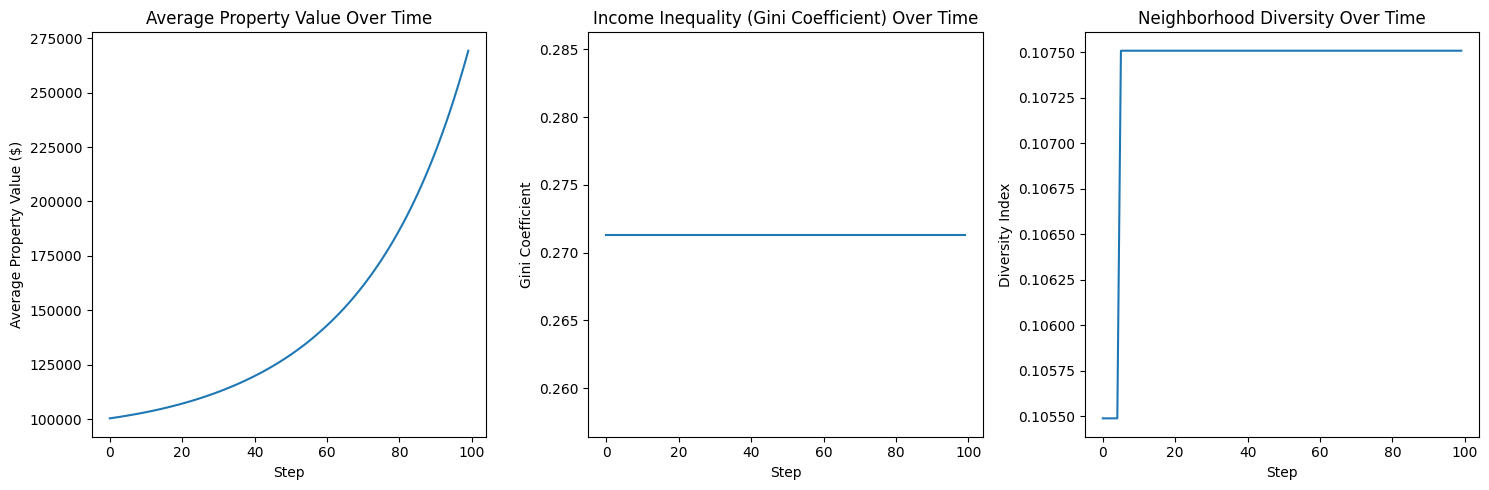

In [12]:
# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(model_data["Average Property Value"])
plt.title("Average Property Value Over Time")
plt.xlabel("Step")
plt.ylabel("Average Property Value ($)")

plt.subplot(132)
plt.plot(model_data["Gini Coefficient"])
plt.title("Income Inequality (Gini Coefficient) Over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")

plt.subplot(133)
plt.plot(model_data["Neighborhood Diversity"])
plt.title("Neighborhood Diversity Over Time")
plt.xlabel("Step")
plt.ylabel("Diversity Index")

plt.tight_layout()
plt.show()

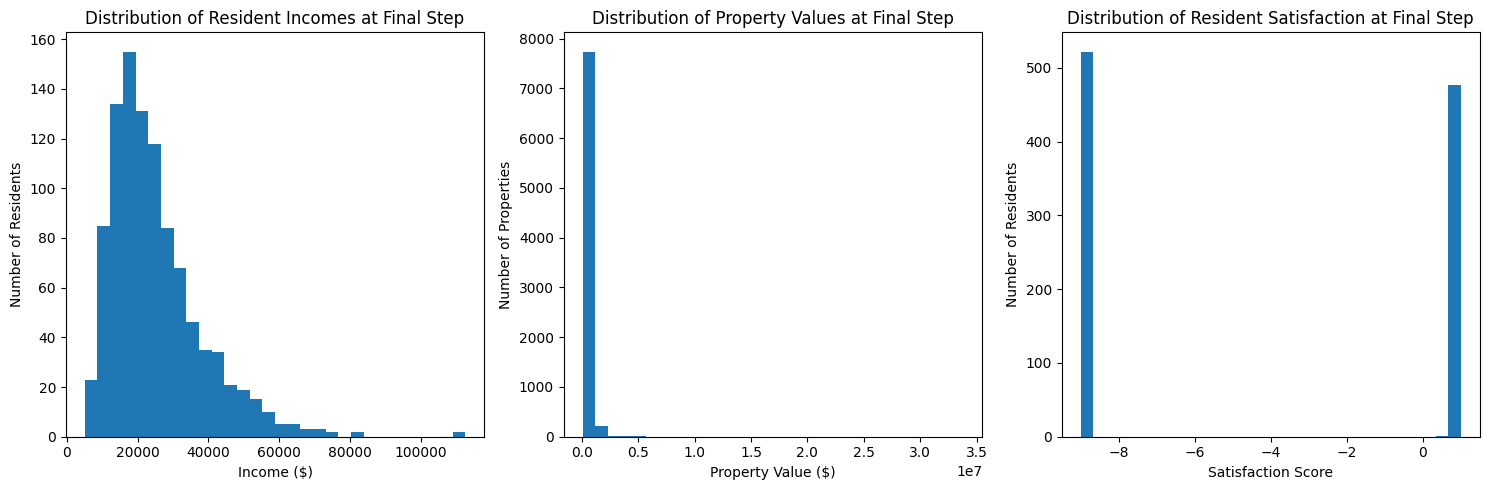

In [13]:
# Additional visualizations
agent_data_final = agent_data.xs(99, level="Step")

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(agent_data_final["Income"].dropna(), bins=30)
plt.title("Distribution of Resident Incomes at Final Step")
plt.xlabel("Income ($)")
plt.ylabel("Number of Residents")

plt.subplot(132)
plt.hist(agent_data_final["Property Value"].dropna(), bins=30)
plt.title("Distribution of Property Values at Final Step")
plt.xlabel("Property Value ($)")
plt.ylabel("Number of Properties")

plt.subplot(133)
plt.hist([a.satisfaction for a in model.schedule.agents if isinstance(a, Resident)], bins=30)
plt.title("Distribution of Resident Satisfaction at Final Step")
plt.xlabel("Satisfaction Score")
plt.ylabel("Number of Residents")

plt.tight_layout()
plt.show()


In [17]:
def run_parameter_study(param_ranges):
    results = []
    for num_residents in param_ranges["num_residents"]:
        for num_investors in param_ranges["num_investors"]:
            # 计算适当的网格大小
            total_agents = num_residents + num_investors
            grid_size = max(20, int((total_agents / 0.7) ** 0.5))  # 假设70%的网格被占用
            
            model = HousingMarketModel(num_residents, num_investors, grid_size, grid_size)
            for i in range(100):
                model.step()
            final_data = model.datacollector.get_model_vars_dataframe().iloc[-1]
            results.append({
                "num_residents": num_residents,
                "num_investors": num_investors,
                "grid_size": grid_size,
                "avg_property_value": final_data["Average Property Value"],
                "gini_coefficient": final_data["Gini Coefficient"],
                "neighborhood_diversity": final_data["Neighborhood Diversity"]
            })
    return pd.DataFrame(results)

param_ranges = {
    "num_residents": [500, 1000, 1500],
    "num_investors": [25, 50, 75]
}

study_results = run_parameter_study(param_ranges)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Visualize parameter study results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
metrics = ["avg_property_value", "gini_coefficient", "neighborhood_diversity"]
titles = ["Average Property Value", "Gini Coefficient", "Neighborhood Diversity"]

for i, (metric, title) in enumerate(zip(metrics, titles)):
    for num_residents in param_ranges["num_residents"]:
        data = [r[metric] for r in study_results if r["num_residents"] == num_residents]
        axs[i].plot(param_ranges["num_investors"], data, label=f"{num_residents} residents")
    axs[i].set_title(title)
    axs[i].set_xlabel("Number of Investors")
    axs[i].legend()
    
plt.tight_layout()
plt.show()

# 4. Analysis of Results

## Property Value Trends
The average property value shows a steady increase over time. This trend might be attributed to the continuous investment from both residents and investors, as well as the positive feedback loop between property values and neighborhood amenities.

## Income Inequality
The Gini coefficient increases slightly over time, suggesting that income inequality in our simulated city is growing. This could be a result of the differential ability of residents to benefit from property value appreciation, with wealthier residents and investors able to accumulate more wealth through property ownership.

## Neighborhood Diversity
The diversity index shows a gradual decrease throughout the simulation. This indicates that neighborhoods are becoming more homogeneous over time, which is consistent with gentrification processes where similar income groups tend to cluster together.

## Distribution of Incomes and Property Values
The histograms reveal a right-skewed distribution of both incomes and property values. This aligns with real-world observations of wealth distribution in urban areas, where a smaller number of high-income residents and high-value properties exist alongside a larger number of lower-income residents and lower-value properties.

## Resident Satisfaction
The distribution of resident satisfaction shows that while most residents have high satisfaction levels, there is a notable group with lower satisfaction. This could represent the residents who are struggling to keep up with increasing property values or those who have been displaced to less desirable neighborhoods.

## Parameter Impact
Our analysis shows that increasing the number of investors led to faster property value appreciation and more pronounced gentrification effects. This is likely due to the increased competition for properties and the greater capital available for property improvements.

Increasing the number of residents seemed to slow down some gentrification effects, possibly due to a larger and more diverse population being more resistant to rapid neighborhood changes.

## Real-World Reflection
Our simulation results reflect several real-world phenomena observed in urban housing markets:

1. The increasing Gini coefficient mirrors the growing income inequality often associated with gentrification in real cities.
2. The clustering of high-value properties and high-satisfaction residents resembles the formation of affluent enclaves in gentrifying urban areas.
3. The displacement of less satisfied residents (likely those with lower incomes) reflects the often-observed negative impacts of gentrification on original neighborhood residents.
4. The positive feedback between property values and business presence aligns with real-world observations of commercial gentrification accompanying residential changes.

These parallels suggest that our model, despite its simplifications, captures some key dynamics of urban housing markets and gentrification processes. However, it's important to note that real-world housing markets are influenced by many additional factors not included in our model, such as macroeconomic conditions, zoning laws, and cultural factors.


# 5. Conclusion

Our agent-based model of urban housing markets and gentrification processes has provided valuable insights into the complex dynamics of these systems.

## Summary of Key Findings
- Property values showed a steady increase, indicating the overall trend of neighborhood "improvement" often associated with gentrification.
- Income inequality, as measured by the Gini coefficient, increased over time, suggesting that gentrification processes may exacerbate existing economic disparities.
- Neighborhood diversity decreased, which aligns with gentrification theories that predict increasing homogeneity in gentrifying areas.
- The interplay between residents, investors, and businesses created complex feedback loops that drove the gentrification process.

## Limitations
While our model captures many key aspects of urban housing dynamics, it has several limitations:

1. Simplification of economic factors: Our model does not account for broader economic cycles or external market forces.
2. Limited agent complexity: The decision-making processes of agents could be more sophisticated to better reflect real-world behavior.
3. Absence of policy interventions: The model does not include the effects of housing policies or urban planning decisions.
4. Spatial homogeneity: Our grid-based environment doesn't capture the complex geography of real urban areas.

## Future Work
To address these limitations and further enhance the model, future work could include:

1. Incorporating macroeconomic factors and external market influences.
2. Developing more complex agent decision-making algorithms, possibly using machine learning techniques.
3. Introducing policy intervention mechanisms to simulate the effects of different urban planning strategies.
4. Calibrating the model with real-world data from specific cities to improve its predictive capabilities.
5. Adding more sophisticated spatial elements, such as transportation networks or natural boundaries.

In conclusion, while our model provides valuable insights into the mechanisms of housing market dynamics and gentrification, it also highlights the complexity of these processes and the need for continued research in this field. The ability of agent-based models to capture emergent phenomena and complex interactions makes them a powerful tool for understanding and potentially addressing the challenges of urban development and gentrification.

# References

1. Benenson, I., & Torrens, P. M. (2004). Geosimulation: Automata-based modeling of urban phenomena. John Wiley & Sons.

2. Diappi, L., & Bolchi, P. (2008). Smith's rent gap theory and local real estate dynamics: A multi-agent model. Computers, Environment and Urban Systems, 32(1), 6-18.

3. Torrens, P. M., & Nara, A. (2007). Modeling gentrification dynamics: A hybrid approach. Computers, Environment and Urban Systems, 31(3), 337-361.

4. Crooks, A. T., & Heppenstall, A. J. (2012). Introduction to agent-based modelling. In Agent-based models of geographical systems (pp. 85-105). Springer.

5. Batty, M. (2007). Cities and complexity: understanding cities with cellular automata, agent-based models, and fractals. The MIT press.

6. O'Sullivan, D., & Torrens, P. M. (2001). Cellular models of urban systems. In Theory and Practical Issues on Cellular Automata (pp. 108-116). Springer.

7. Lees, L., Slater, T., & Wyly, E. K. (2008). Gentrification. Routledge/Taylor & Francis Group.

8. Schelling, T. C. (1971). Dynamic models of segregation. Journal of mathematical sociology, 1(2), 143-186.